In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

---

# 1. Load and prepare CAMELS-CH data

In [3]:
camels_config = CamelsCHConfig(
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
    timeseries_pattern="CAMELS_CH_obs_based_*.csv",
    static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
    use_climate=False,
    use_geology=False,
    use_glacier=False,
    use_human_influence=False,
    use_hydrogeology=False,
    use_hydrology=False,
    use_landcover=False,
    use_soil=False,
    use_topographic=False,
)

In [4]:
all_gauge_ids = get_all_gauge_ids(camels_config)
ids_for_training = all_gauge_ids[:10]


camels = CamelsCH(camels_config)
camels.load_stations(ids_for_training)

Loaded time series data for 10 stations


In [5]:
# static = camels.get_static_attributes()
# # q_mean	runoff_ratio	stream_elas	slope_fdc	baseflow_index_landson	hfd_mean
# static = static[["gauge_id", "q_mean", "runoff_ratio", "stream_elas", "slope_fdc", "baseflow_index_landson", "hfd_mean"]]
# static

In [6]:
data = camels.get_time_series()
data = data[
    [
        "gauge_id",
        "date",
        "discharge_spec(mm/d)",
        "precipitation(mm/d)",
        "temperature_mean(degC)",
    ]
]



# 2. Configure preprocessing

In [7]:
preprocessing_config = {
    "features": {
        "scale_method": "per_basin",
        "log_transform": []
    },
    "target": {
        "scale_method": "per_basin",
        "log_transform": False
    },
    "static_features": {
        "scale_method": "global"
    }
}

# 3. Create DataModule

In [8]:
data_module = HydroDataModule(
    time_series_df=data,
    static_df=None,
    preprocessing_config=preprocessing_config,
    batch_size=32,
    input_length=30,
    output_length=5,
    num_workers=4,
    features=["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"],
    target="discharge_spec(mm/d)",
    train_years=10,
    val_years=1,
    min_test_years=1,
)

## 4. Create model and train

In [9]:
from src.models.lstm import LitLSTM
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [10]:
model = LitLSTM(
    input_size=3,
    hidden_size=64,
    num_layers=1,
    output_size=5,
    target="discharge_spec(mm/d)",
)


# Configure trainer
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Us


Quality Check Summary:
Original basins: 10
Retained basins: 5
Excluded basins: 5

Data preprocessing completed:
- Features scaled using per_basin method
- Target scaled using per_basin method
- Log transforms applied to: [] and target: False
Created 18090 valid sequences.
Created 1655 valid sequences.

Data split summary:
Training: 18260 samples from 5 basins
Validation: 1825 samples from 5 basins
Testing: 46026 samples from 5 basins
Epoch 4: 100%|██████████| 566/566 [00:04<00:00, 118.97it/s, v_num=28]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 566/566 [00:04<00:00, 118.94it/s, v_num=28]


In [11]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [ ]:
ids_for_training

In [13]:
trainer.test(model, data_module)
test_results = model.test_results


Quality Check Summary:
Original basins: 10
Retained basins: 5
Excluded basins: 5

Data preprocessing completed:
- Features scaled using per_basin method
- Target scaled using per_basin method
- Log transforms applied to: [] and target: False
Created 45856 valid sequences.

Data split summary:
Training: 18260 samples from 5 basins
Validation: 1825 samples from 5 basins
Testing: 46026 samples from 5 basins
Testing DataLoader 0: 100%|██████████| 1433/1433 [00:04<00:00, 335.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_MAE_h1          0.17798486351966858
       test_MAE_h2          0.2838926911354065
       test_MAE_h3          0.3390244245529175
       test_MAE_h4          0.3794221878051758
       test_MAE_h5          0.41010802984

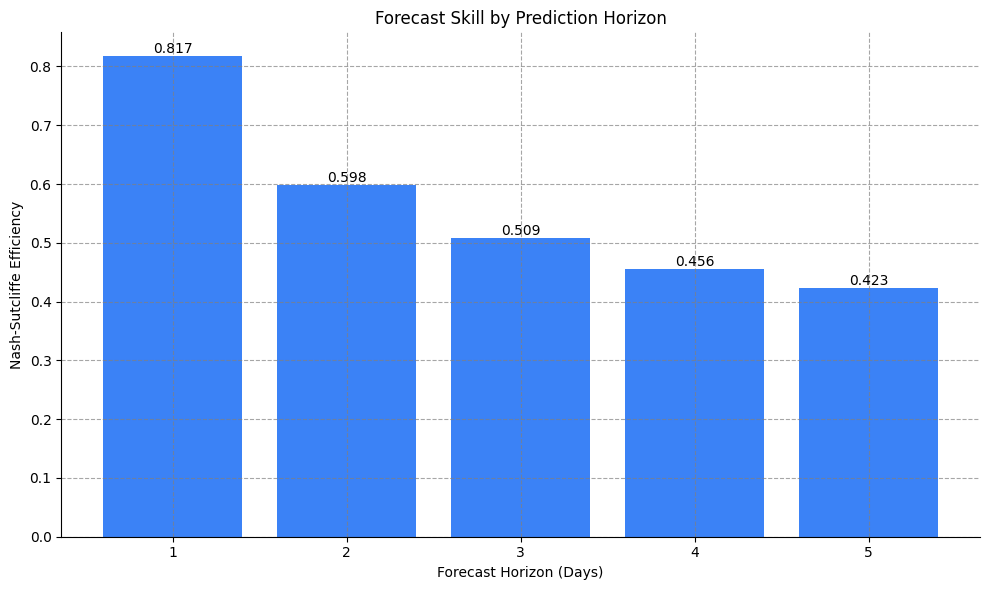

In [14]:
# Get the results
results_df = model.test_results["forecast_df"]
horizon_metrics = model.test_results["horizon_metrics"]

horizons = []
nse_values = []
for horizon, metrics in horizon_metrics.items():
    horizons.append(horizon)
    nse_values.append(metrics["NSE"])

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(horizons, nse_values, color="#3b82f6")

# Customize plot
plt.xlabel("Forecast Horizon (Days)")
plt.ylabel("Nash-Sutcliffe Efficiency")
plt.title("Forecast Skill by Prediction Horizon")
plt.grid(True, linestyle="--", alpha=0.7, color="gray")
sns.despine()

# Set x-axis ticks to show all horizons
plt.xticks(horizons)

# Add value labels on top of each bar
for i, v in enumerate(nse_values):
    plt.text(i + 1, v, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()